In [1]:
# Import packages & setup dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from funky import extractor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# names=['ID', 'M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'gen_max', 'DV']
df_gc = extractor('gc')
df_nsc = extractor('nsc')
df_ysc = extractor('ysc')

# RFClassifier

## First Generation

In [9]:
def classes(gen):
    if gen > 3: return 4
    return gen


df_nsc['target'] = df_nsc['gen_max'].transform(classes)
df_nsc['DV'] = df_nsc['esca_v'].ge(df_nsc['kick'])  # Escape velocity is greater than kick (bbh stays in cluster)

In [10]:
min_evo = df_nsc.loc[df_nsc.groupby('ID')['gen'].idxmin()]

In [18]:
# separate test set, create label set
dumped_features = ['ID', 'gen', 'gen_max', 'target', 'kick', 'esca_v', 'Mcluster']

x_train, x_test, y_train, y_test = train_test_split((train_feats := min_evo.drop(columns=dumped_features)), min_evo['target'], test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(classification_report(y_test, forest.predict(x_test)))
print(f'train size: {len(min_evo)}\ntest size: {len(y_test)}')
#print(forest.score(nsc_test, fate_test))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00    479434
           3       0.91      0.60      0.73     32182
           4       0.18      0.65      0.28      4330

    accuracy                           0.97    515946
   macro avg       0.70      0.75      0.67    515946
weighted avg       0.99      0.97      0.98    515946

train size: 2579726
test size: 515946


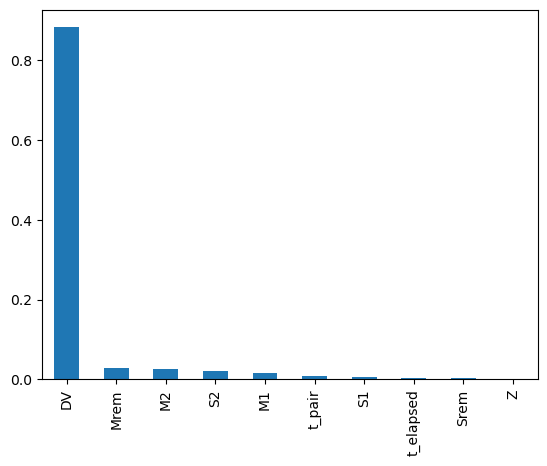

In [19]:
importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar()
plt.show()

In [21]:
forest.fit(x_train[['DV', 'Mrem']], y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10,
                       n_jobs=-1, random_state=1758)

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_plot/decision_boundary.py:191: UserWarning: The following kwargs were not used by contour: 'lw'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


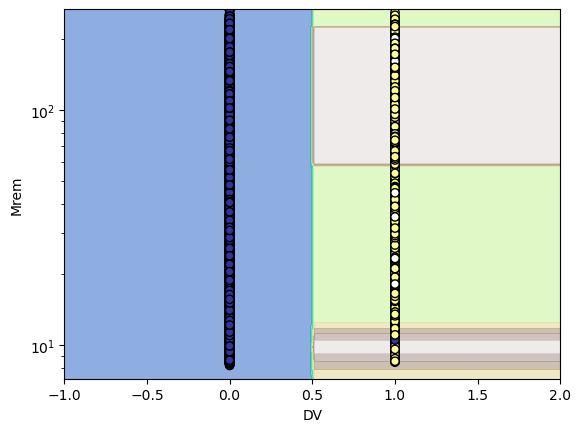

In [22]:
display = DecisionBoundaryDisplay.from_estimator(forest, x_train[['DV', 'Mrem']], response_method="predict", alpha=.5, cmap='terrain')
display.ax_.scatter(x_train['DV'], x_train['Mrem'], edgecolor='k', c=y_train, lw=.5, cmap='terrain')
plt.yscale('log')
plt.show()

/home/teobaldo/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


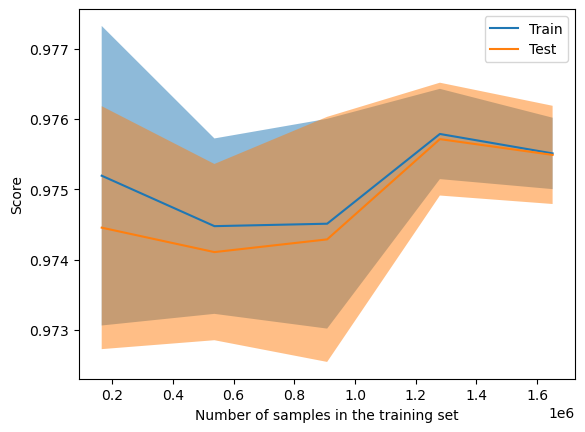

In [15]:
learn = LearningCurveDisplay.from_estimator(forest, x_train[['DV', 'Mcluster']], y_train, n_jobs=-1, random_state=1758)


## Targeted generation

In [6]:
gen_prec = df_nsc[df_nsc['gen'] == 4]

In [7]:
# separate test set, create label set
dumped_features = ['ID', 'gen', 'gen_max', 'target', 'kick', 'esca_v']

x_train, x_test, y_train, y_test = train_test_split((train_feats := gen_prec.drop(columns=dumped_features)), gen_prec['gen_max'] > 4, test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
#print(classification_report(fate_test, forest.predict(nsc_test)))
print(f'train size: {len(gen_prec)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 21486
test size: 4298
0.9997673336435552


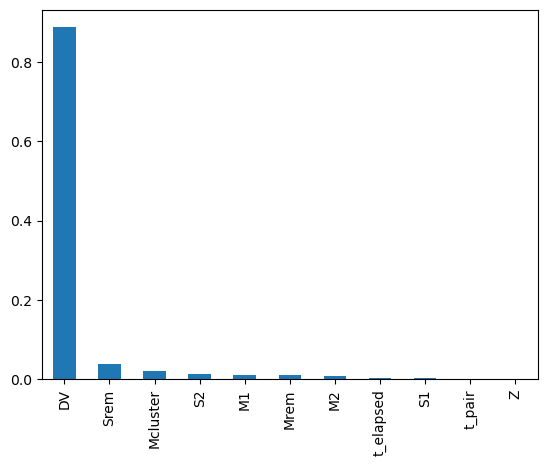

In [8]:
importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar()
plt.show()

In [9]:
forest.fit(x_train[['DV', 'Z']], y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10,
                       n_jobs=-1, random_state=1758)

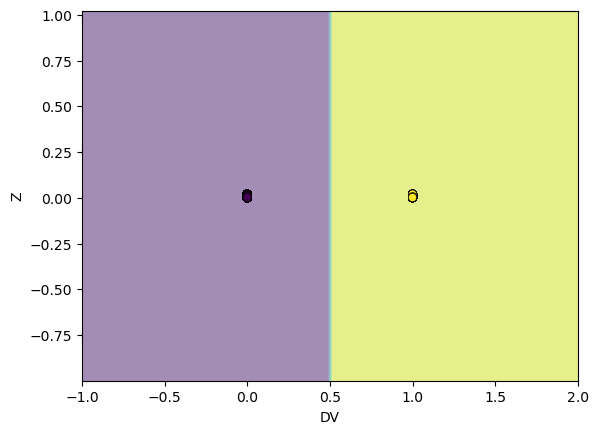

In [10]:
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[['DV', 'Z']], response_method="predict", alpha=.5)
display.ax_.scatter(x_test['DV'], x_test['Z'], edgecolor='k', c=y_test, lw=0.5)
plt.show()

# RFRegressor

## Relativistic Kick

In [85]:
dumped_features = ['ID', 'gen_max', 'target', 'kick', 'DV', 'esca_v']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['kick'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.08553893066107321


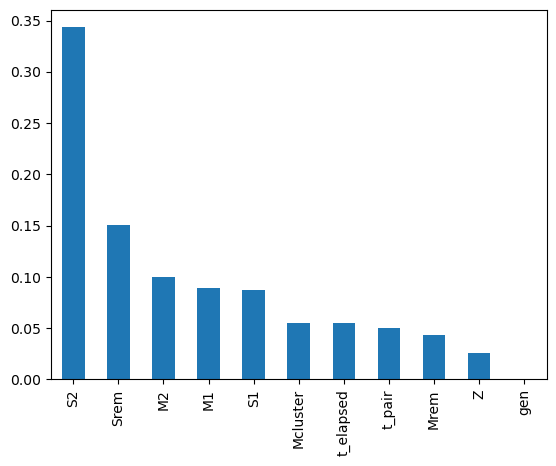

In [86]:
importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar()
plt.show()

In [87]:
forest.fit(x_train[['S2', 'Srem']], y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1,
                      random_state=1758)

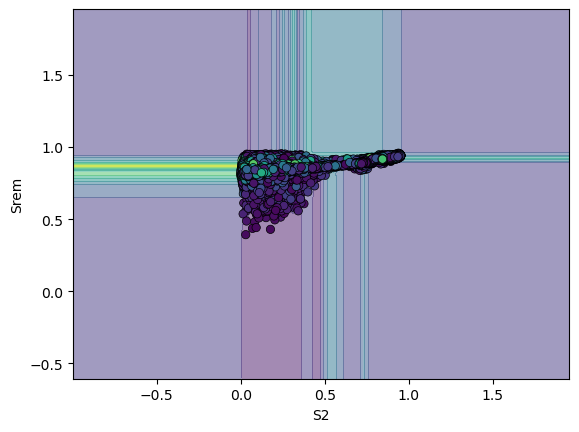

In [88]:
display = DecisionBoundaryDisplay.from_estimator(forest, x_train[['S2', 'Srem']], response_method="predict", alpha=.5)
display.ax_.scatter(x_train['S2'], x_train['Srem'], edgecolor='k', c=y_train, lw=0.5)
plt.show()

## Spin of the Remnant

In [11]:
dumped_features = ['ID', 'Srem', 'gen_max', 'DV', 'target', 'esca_v', 'Mcluster']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Srem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.995520826383472


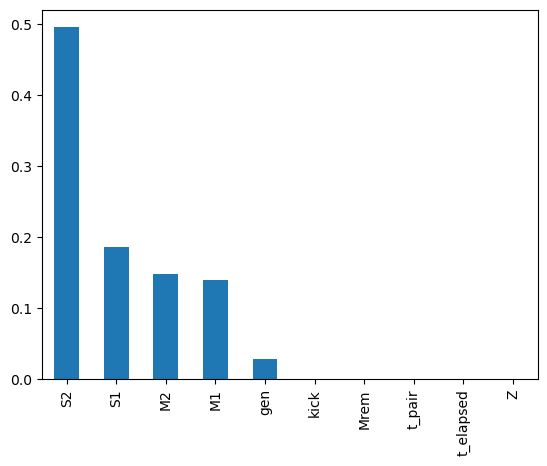

In [12]:
importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar()
plt.show()

In [13]:
forest.fit(x_train[['S2', 'S1']], y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1,
                      random_state=1758)

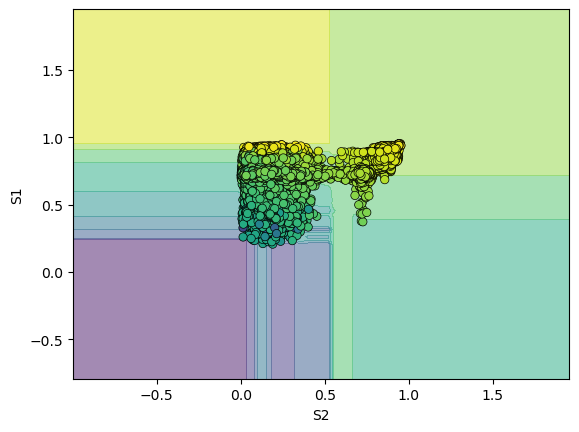

In [14]:
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[['S2', 'S1']], response_method="predict", alpha=.5)
display.ax_.scatter(x_test['S2'], x_test['S1'], edgecolor='k', c=y_test, lw=0.5)
plt.show()

In [85]:
dumped_features = ['ID', 'gen_max', 'target', 'kick', 'DV', 'esca_v']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['kick'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.08553893066107321


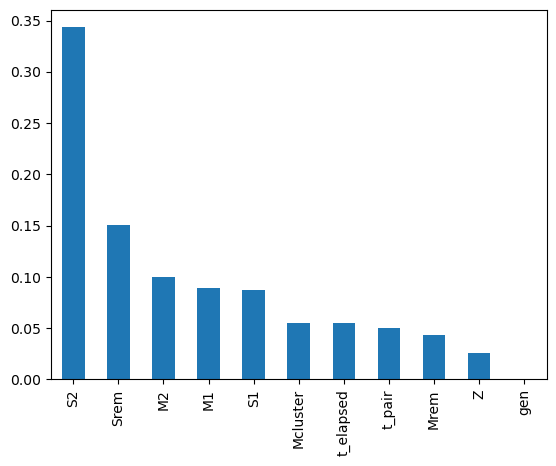

In [86]:
importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar()
plt.show()

In [87]:
forest.fit(x_train[['S2', 'Srem']], y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1,
                      random_state=1758)

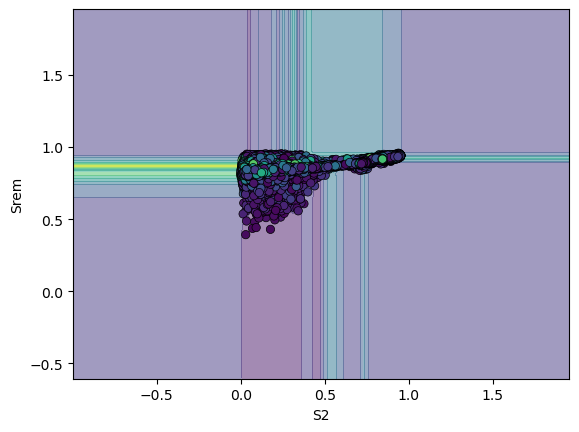

In [88]:
display = DecisionBoundaryDisplay.from_estimator(forest, x_train[['S2', 'Srem']], response_method="predict", alpha=.5)
display.ax_.scatter(x_train['S2'], x_train['Srem'], edgecolor='k', c=y_train, lw=0.5)
plt.show()

## Mass of the Remnant

In [26]:
dumped_features = ['ID', 'Srem', 'gen_max', 'DV', 'target', 'esca_v', 'Mcluster', 'Mrem', 'gen']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Mrem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.9897021711311191


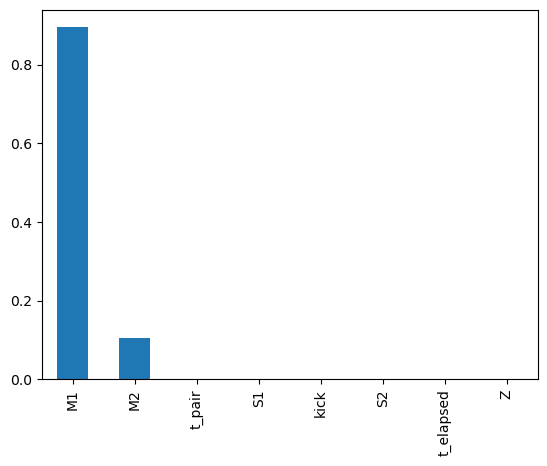

In [27]:
importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar()
plt.show()

In [28]:
forest.fit(x_train[['M1', 'M2']], y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1,
                      random_state=1758)

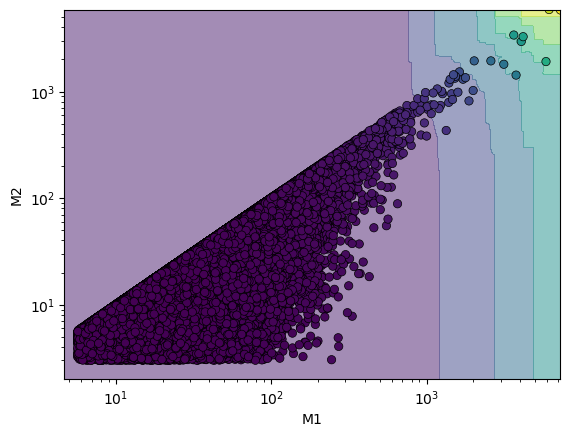

In [30]:
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[['M1', 'M2']], response_method="predict", alpha=.5)
display.ax_.scatter(x_test['M1'], x_test['M2'], edgecolor='k', c=y_test, lw=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()